In [ ]:
pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path = '/content/drive/MyDrive/transactions.json'

In [4]:
#Loading all the packages
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (precision_score, recall_score, roc_auc_score, accuracy_score,
                               confusion_matrix, precision_recall_curve, roc_curve, brier_score_loss)

In [5]:
# Reading JSON data from a file, handling potential multiple objects
json_data = []
with open(file_path) as f:
    for line in f:
        try:
            json_data.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Warning: Skipping invalid JSON line: {line.strip()}")

# Converting JSON data to a pandas DataFrame
if json_data:
    df = pd.DataFrame(json_data)
    print(df.head())
else:
    print("No valid JSON data found in the file.")

  accountNumber customerId  creditLimit  availableMoney  transactionDateTime  \
0     737265056  737265056       5000.0          5000.0  2016-08-13T14:27:32   
1     737265056  737265056       5000.0          5000.0  2016-10-11T05:05:54   
2     737265056  737265056       5000.0          5000.0  2016-11-08T09:18:39   
3     737265056  737265056       5000.0          5000.0  2016-12-10T02:14:50   
4     830329091  830329091       5000.0          5000.0  2016-03-24T21:04:46   

   transactionAmount         merchantName acqCountry merchantCountryCode  \
0              98.55                 Uber         US                  US   
1              74.51          AMC #191138         US                  US   
2               7.47           Play Store         US                  US   
3               7.47           Play Store         US                  US   
4              71.18  Tim Hortons #947751         US                  US   

  posEntryMode  ... echoBuffer currentBalance merchantCity mer

In [32]:
df.shape

(786363, 29)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   accountNumber             786363 non-null  object        
 1   customerId                786363 non-null  object        
 2   creditLimit               786363 non-null  float64       
 3   availableMoney            786363 non-null  float64       
 4   transactionDateTime       786363 non-null  datetime64[ns]
 5   transactionAmount         786363 non-null  float64       
 6   merchantName              786363 non-null  object        
 7   acqCountry                786363 non-null  object        
 8   merchantCountryCode       786363 non-null  object        
 9   posEntryMode              786363 non-null  object        
 10  posConditionCode          786363 non-null  object        
 11  merchantCategoryCode      786363 non-null  object        
 12  cu

In [34]:
# replace feature that's entirely space (or empty) with NaN
print(df.replace(r'^\s*$', np.nan, regex=True))

       accountNumber customerId  creditLimit  availableMoney  \
0          737265056  737265056       5000.0         5000.00   
1          737265056  737265056       5000.0         5000.00   
2          737265056  737265056       5000.0         5000.00   
3          737265056  737265056       5000.0         5000.00   
4          830329091  830329091       5000.0         5000.00   
...              ...        ...          ...             ...   
786358     732852505  732852505      50000.0        48904.96   
786359     732852505  732852505      50000.0        48785.04   
786360     732852505  732852505      50000.0        48766.15   
786361     732852505  732852505      50000.0        48716.72   
786362     732852505  732852505      50000.0        48666.83   

       transactionDateTime  transactionAmount         merchantName acqCountry  \
0      2016-08-13 14:27:32              98.55                 Uber         US   
1      2016-10-11 05:05:54              74.51          AMC #191138   

In [35]:
#Basic Summary statistics
df.describe()

,creditLimit,availableMoney,transactionDateTime,transactionAmount,currentExpDate,accountOpenDate,dateOfLastAddressChange,currentBalance
count,786363.000000,786363.000000,786363,786363.000000,786363,786363,786363,786363.000000
mean,10759.464459,6250.725369,2016-07-06 01:58:58.395681536,136.985791,2026-09-25 23:50:42.724542720,2014-02-03 01:11:17.352825856,2015-04-14 06:46:41.127723520,4508.739089
min,250.000000,-1005.630000,2016-01-01 00:01:02,0.000000,2019-12-01 00:00:00,1989-08-22 00:00:00,1989-08-22 00:00:00,0.000000
25%,5000.000000,1077.420000,2016-04-06 19:35:07,33.650000,2023-05-01 00:00:00,2013-06-29 00:00:00,2014-10-08 00:00:00,689.910000
50%,7500.000000,3184.860000,2016-07-08 05:03:57,87.900000,2026-10-01 00:00:00,2014-09-05 00:00:00,2016-01-13 00:00:00,2451.760000
75%,15000.000000,7500.000000,2016-10-05 13:52:03.500000,191.480000,2030-03-01 00:00:00,2015-05-04 00:00:00,2016-06-06 00:00:00,5291.095000
max,50000.000000,50000.000000,2016-12-30 23:59:45,2011.540000,2033-08-01 00:00:00,2015-12-31 00:00:00,2016-12-30 00:00:00,47498.810000
std,11636.174890,8880.783989,NaN,147.725569,NaN,NaN,NaN,6457.442068


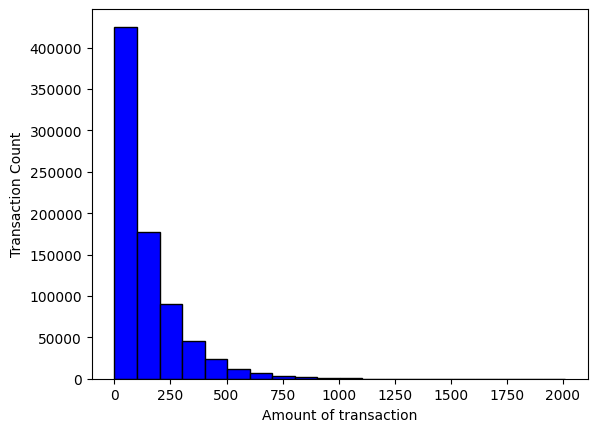

<Figure size 2500x1500 with 0 Axes>

In [36]:
plt.hist(df['transactionAmount'], color='blue', edgecolor='black', bins=20)
plt.xlabel('Amount of transaction', fontsize=10)
plt.ylabel('Transaction Count', fontsize=10)
plt.figure(figsize=(25,15))
plt.show()

In [37]:
# Q1 or quartile 1 represents the 25th percentile of the data
# Q2 or quartile 2 represents the 50th percentile of the data
# Q3 or quartile 3 represents the 75th percentile of the data
# IQR is the range between the first and the third quartiles
# Q3 + 1.5 IQR are outliers

In [38]:
# plt.scatter(df.index, df['transactionAmount'], color='blue', edgecolor='black')
# plt.xlabel('Index', fontsize=10)
# plt.ylabel('Amount of transaction', fontsize=10)
# plt.show()

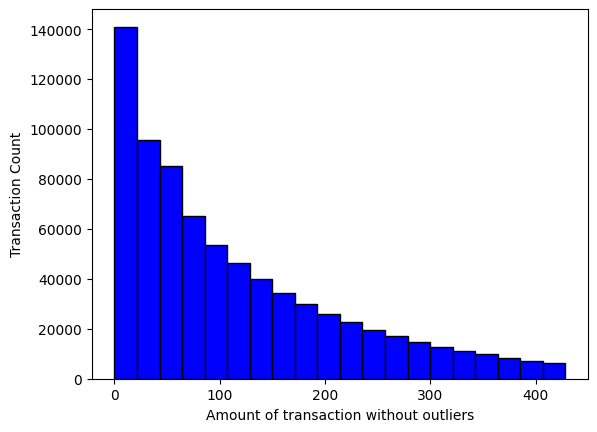

In [39]:
q1, q3 = np.percentile(sorted(df.transactionAmount),[25,75])
iqr = q3 - q1
lower_limit = 0
upper_limit = q3 + (1.5 * iqr)
x = df.transactionAmount[df.transactionAmount.between(lower_limit, upper_limit)]
plt.hist(x, color='blue', edgecolor='black', bins=20)
plt.xlabel('Amount of transaction without outliers', fontsize=10)
plt.ylabel('Transaction Count', fontsize=10)
plt.show()

In [83]:
df['echoBuffer'].value_counts()

echoBuffer
    786363
Name: count, dtype: int64

In [40]:
# Data Wrangling - To spot duplicate transactions

In [41]:
# The criteria given for a duplicate transaction:
# a) reversed transaction, where a purchase is followed by a reversal
# b) multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span

In [42]:
# Identifying the count of each transaction type
df['transactionType'].value_counts()

transactionType
PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
                           698
Name: count, dtype: int64

In [43]:
#Converting time columns to standard format using datetime function of pandas
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'], infer_datetime_format=True)
df['currentExpDate'] = pd.to_datetime(df['currentExpDate'], infer_datetime_format=True)
df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'], infer_datetime_format=True)
df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'], infer_datetime_format=True)

<ipython-input-43-3880a832da3c>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'], infer_datetime_format=True)
<ipython-input-43-3880a832da3c>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['currentExpDate'] = pd.to_datetime(df['currentExpDate'], infer_datetime_format=True)
<ipython-input-43-3880a832da3c>:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/p

In [44]:
#  To identify a duplicated transaction, we need to consider matching
# 'accountNumber', 'customerId', 'transactionAmount', 'merchantName'
#  These columns will contain information based on the exact account number and customer id from where
# the transaction began, the exact transaction amount to the exact merchant

In [45]:
# Creating a data frame to gather all the duplicated transactions using duplicated pandas function

In [46]:
duplicated_df = df[df.duplicated(['accountNumber', 'customerId', 'transactionAmount', 'merchantName'], keep=False)]

In [47]:
print("Dataframe with duplicated transactions", duplicated_df)

Dataframe with duplicated transactions        accountNumber customerId  creditLimit  availableMoney  \
2          737265056  737265056       5000.0         5000.00   
3          737265056  737265056       5000.0         5000.00   
11         830329091  830329091       5000.0         5000.00   
12         830329091  830329091       5000.0         4959.25   
13         830329091  830329091       5000.0         4918.50   
...              ...        ...          ...             ...   
786346     732852505  732852505      50000.0        49536.24   
786348     732852505  732852505      50000.0        49251.72   
786352     732852505  732852505      50000.0        49848.35   
786357     732852505  732852505      50000.0        48956.44   
786359     732852505  732852505      50000.0        48785.04   

       transactionDateTime  transactionAmount        merchantName acqCountry  \
2      2016-11-08 09:18:39               7.47          Play Store         US   
3      2016-12-10 02:14:50      

In [48]:
# Splitting this new duplicated data frame based on 'transactionType'

In [49]:
purchased_df = duplicated_df[duplicated_df.transactionType == 'PURCHASE']
reversed_df = duplicated_df[duplicated_df.transactionType == 'REVERSAL']


In [50]:
print("The shape of the purchased transaction data frame is : ", purchased_df.shape)
print("The shape of the reversed transaction data frame is : ", reversed_df.shape)

The shape of the purchased transaction data frame is :  (83252, 29)
The shape of the reversed transaction data frame is :  (18363, 29)


In [51]:
# The next step is to merge these dataframes(purchased and reversed) and create a dataframe
# comprising of only transactions in common

In [52]:
net_transaction = pd.merge(purchased_df, reversed_df, on=['accountNumber', 'customerId', 'transactionAmount', 'merchantName'], how='inner', indicator = True)
net_transaction.shape

(18143, 55)

In [53]:
net_transaction

,accountNumber,customerId,creditLimit_x,availableMoney_x,transactionDateTime_x,transactionAmount,merchantName,acqCountry_x,merchantCountryCode_x,posEntryMode_x,...,currentBalance_y,merchantCity_y,merchantState_y,merchantZip_y,cardPresent_y,posOnPremises_y,recurringAuthInd_y,expirationDateKeyInMatch_y,isFraud_y,_merge
0,574788567,574788567,2500.0,2416.11,2016-05-24 01:35:33,215.13,Convenient Tire,US,US,09,...,299.02,,,,True,,,False,False,both
1,924729945,924729945,50000.0,50000.00,2016-10-04 04:20:04,168.57,discount.com,US,US,05,...,168.57,,,,False,,,False,False,both
2,984504651,984504651,50000.0,49138.85,2016-01-06 04:08:06,83.64,1st Sandwitch Bar #801388,US,US,09,...,11909.30,,,,True,,,False,False,both
3,984504651,984504651,50000.0,46818.15,2016-01-16 09:52:30,450.74,Planet Fitness #849960,US,US,05,...,3632.59,,,,False,,,False,False,both
4,984504651,984504651,50000.0,46341.05,2016-01-17 08:13:08,81.73,AMC #724446,US,US,09,...,8090.70,,,,True,,,False,False,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18138,205026043,205026043,5000.0,1627.52,2016-09-18 06:07:17,56.26,Lyft,US,US,05,...,3428.74,,,,False,,,False,False,both
18139,288358186,288358186,7500.0,7407.25,2016-08-02 18:42:42,20.66,ebay.com,US,US,09,...,132.45,,,,False,,,False,False,both
18140,638498773,638498773,10000.0,10000.00,2016-01-01 19:45:47,201.79,KFC #928167,US,US,05,...,201.79,,,,True,,,False,False,both
18141,638498773,638498773,10000.0,1271.91,2016-10-09 04:52:23,86.14,Dunkin' Donuts #396342,US,US,05,...,4668.67,,,,True,,,False,False,both


In [54]:
net_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18143 entries, 0 to 18142
Data columns (total 55 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   accountNumber               18143 non-null  object        
 1   customerId                  18143 non-null  object        
 2   creditLimit_x               18143 non-null  float64       
 3   availableMoney_x            18143 non-null  float64       
 4   transactionDateTime_x       18143 non-null  datetime64[ns]
 5   transactionAmount           18143 non-null  float64       
 6   merchantName                18143 non-null  object        
 7   acqCountry_x                18143 non-null  object        
 8   merchantCountryCode_x       18143 non-null  object        
 9   posEntryMode_x              18143 non-null  object        
 10  posConditionCode_x          18143 non-null  object        
 11  merchantCategoryCode_x      18143 non-null  object    

In [55]:
# The reversed transaction can be captured if the purchase time < reversed time i.e
# transactionDateTime_x < transactionDateTime_y

In [56]:
captured_reversed_transaction = net_transaction[net_transaction.transactionDateTime_x
                                                < net_transaction.transactionDateTime_y]
print("The shape of the reversed transaction data frame is : ", captured_reversed_transaction.shape)

The shape of the reversed transaction data frame is :  (17999, 55)


In [57]:
captured_reversed_transaction

,accountNumber,customerId,creditLimit_x,availableMoney_x,transactionDateTime_x,transactionAmount,merchantName,acqCountry_x,merchantCountryCode_x,posEntryMode_x,...,currentBalance_y,merchantCity_y,merchantState_y,merchantZip_y,cardPresent_y,posOnPremises_y,recurringAuthInd_y,expirationDateKeyInMatch_y,isFraud_y,_merge
0,574788567,574788567,2500.0,2416.11,2016-05-24 01:35:33,215.13,Convenient Tire,US,US,09,...,299.02,,,,True,,,False,False,both
1,924729945,924729945,50000.0,50000.00,2016-10-04 04:20:04,168.57,discount.com,US,US,05,...,168.57,,,,False,,,False,False,both
2,984504651,984504651,50000.0,49138.85,2016-01-06 04:08:06,83.64,1st Sandwitch Bar #801388,US,US,09,...,11909.30,,,,True,,,False,False,both
3,984504651,984504651,50000.0,46818.15,2016-01-16 09:52:30,450.74,Planet Fitness #849960,US,US,05,...,3632.59,,,,False,,,False,False,both
4,984504651,984504651,50000.0,46341.05,2016-01-17 08:13:08,81.73,AMC #724446,US,US,09,...,8090.70,,,,True,,,False,False,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18138,205026043,205026043,5000.0,1627.52,2016-09-18 06:07:17,56.26,Lyft,US,US,05,...,3428.74,,,,False,,,False,False,both
18139,288358186,288358186,7500.0,7407.25,2016-08-02 18:42:42,20.66,ebay.com,US,US,09,...,132.45,,,,False,,,False,False,both
18140,638498773,638498773,10000.0,10000.00,2016-01-01 19:45:47,201.79,KFC #928167,US,US,05,...,201.79,,,,True,,,False,False,both
18141,638498773,638498773,10000.0,1271.91,2016-10-09 04:52:23,86.14,Dunkin' Donuts #396342,US,US,05,...,4668.67,,,,True,,,False,False,both


In [58]:
# Consolidating the reversed transaction data frame with required attributes
captured_reversed_transaction = captured_reversed_transaction[['accountNumber', 'customerId',
                                                               'transactionAmount', 'merchantName',
                                                                'transactionDateTime_x', 'transactionDateTime_y',
                                                             'transactionType_x', 'transactionType_y']]
print("The shape of the final reversed transaction data frame is : ", captured_reversed_transaction.shape)

The shape of the final reversed transaction data frame is :  (17999, 8)


In [59]:
captured_reversed_transaction.head(10)

,accountNumber,customerId,transactionAmount,merchantName,transactionDateTime_x,transactionDateTime_y,transactionType_x,transactionType_y
0,574788567,574788567,215.13,Convenient Tire,2016-05-24 01:35:33,2016-05-24 01:38:03,PURCHASE,REVERSAL
1,924729945,924729945,168.57,discount.com,2016-10-04 04:20:04,2016-10-19 14:01:45,PURCHASE,REVERSAL
2,984504651,984504651,83.64,1st Sandwitch Bar #801388,2016-01-06 04:08:06,2016-02-04 00:14:42,PURCHASE,REVERSAL
3,984504651,984504651,450.74,Planet Fitness #849960,2016-01-16 09:52:30,2016-01-16 09:53:15,PURCHASE,REVERSAL
4,984504651,984504651,81.73,AMC #724446,2016-01-17 08:13:08,2016-01-25 20:39:15,PURCHASE,REVERSAL
5,984504651,984504651,53.44,WSC #653684,2016-01-26 19:58:33,2016-02-12 12:47:03,PURCHASE,REVERSAL
6,984504651,984504651,34.73,NYSC #91039,2016-02-01 14:52:45,2016-02-11 20:32:35,PURCHASE,REVERSAL
7,984504651,984504651,34.92,Golds Gym #747443,2016-02-12 05:08:23,2016-02-12 05:10:49,PURCHASE,REVERSAL
8,984504651,984504651,239.96,34th Pub,2016-02-15 09:23:54,2016-02-27 21:30:09,PURCHASE,REVERSAL
9,984504651,984504651,140.86,Universe Massage #178284,2016-03-10 02:17:46,2016-04-04 06:26:07,PURCHASE,REVERSAL


In [60]:
captured_reversed_transaction['transactionAmount'].sum()

2701311.87

In [61]:
# The second criteria of multiple swipes can be handled by:
# a) Using purchase_type = purchase
# b) With the customerId, accountNumber, same transaction amout and merchant
# c) Multiple swipes within an hour

In [62]:
# Reusing purchased dataframe from above and arranging them by transaction time in order to group back to back transactions with exact card
print("The shape of the purchased dataframe is:", purchased_df.shape)
# purchased_df.sort_values(['transactionDateTime'])
purchased_df = purchased_df.sort_values(['accountNumber', 'customerId', 'transactionAmount', 'transactionDateTime'])
print(purchased_df.head(5))

The shape of the purchased dataframe is: (83252, 29)
       accountNumber customerId  creditLimit  availableMoney  \
541919     100088067  100088067      50000.0        50000.00   
541926     100088067  100088067      50000.0        49695.85   
541929     100088067  100088067      50000.0        50000.00   
541936     100088067  100088067      50000.0        50000.00   
541945     100088067  100088067      50000.0        49867.31   

       transactionDateTime  transactionAmount  merchantName acqCountry  \
541919 2016-05-05 22:47:50               3.96  Apple iTunes         US   
541926 2016-06-05 22:10:41               3.96  Apple iTunes         US   
541929 2016-07-05 22:22:49               3.96  Apple iTunes         US   
541936 2016-08-05 00:55:48               3.96  Apple iTunes         US   
541945 2016-09-05 13:14:22               3.96  Apple iTunes         US   

       merchantCountryCode posEntryMode  ... echoBuffer currentBalance  \
541919                  US           09  ..

In [63]:
# Calculating time difference with the preceeding time of the transactionDateTime column using diff and
# dt function and converting it to hours, since we'll be gathering multiple swipes in an hour

In [64]:
purchased_df['time_diff'] = purchased_df.groupby(['accountNumber', 'customerId', 'merchantName', 'transactionAmount'])['transactionDateTime'].diff(1).dt.total_seconds() / 3600
multi_swipe_df = purchased_df

In [85]:
multi_swipe_df['time_diff'].head(5)

541956    0.000556
151518    0.016389
151513    0.032222
151427    0.001111
151428    0.049444
Name: time_diff, dtype: float64

In [65]:
# Calculating the shape of the new dataframe
multi_swipe_df.shape

(83252, 30)

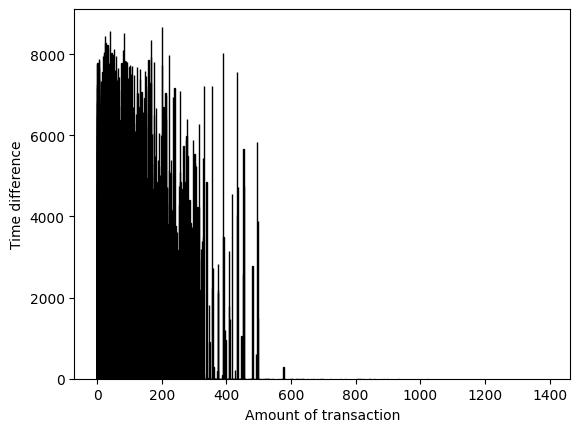

<Figure size 2500x1500 with 0 Axes>

In [ ]:
plt.bar(multi_swipe_df['transactionAmount'], multi_swipe_df['time_diff'],color='black', edgecolor='black')
plt.xlabel('Amount of transaction', fontsize=10)
plt.ylabel('Time difference', fontsize=10)
plt.figure(figsize=(25,15))
plt.show()
# This plot shows that most of the repeated transactions were under 600 units of amount

In [66]:
# Extracting transactions with multiple swipes less than an hour
multi_swipe_df = multi_swipe_df[multi_swipe_df.time_diff< 1]

In [67]:
multi_swipe_df.shape

(7450, 30)

In [68]:
multi_swipe_df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,time_diff
541956,100088067,100088067,50000.0,49275.09,2016-10-16 18:01:02,411.35,Fresh Flowers,US,US,02,...,724.91,,,,False,,,False,False,0.000556
151518,100737756,100737756,250.0,177.98,2016-07-10 14:32:06,43.25,34th BBQ #166379,US,US,02,...,72.02,,,,True,,,False,False,0.016389
151513,100737756,100737756,250.0,250.00,2016-07-02 12:07:00,211.22,South Steakhouse #73819,US,US,09,...,0.00,,,,True,,,False,False,0.032222
151427,100737756,100737756,250.0,-44.75,2016-01-18 01:55:28,693.50,Franks Deli,US,US,05,...,294.75,,,,True,,,False,False,0.001111
151428,100737756,100737756,250.0,-535.03,2016-01-18 01:58:26,693.50,Franks Deli,US,US,05,...,785.03,,,,True,,,False,False,0.049444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388759,999086814,999086814,10000.0,5418.98,2016-08-04 00:04:03,172.50,staples.com,US,US,05,...,4581.02,,,,False,,,False,False,0.026667
388400,999086814,999086814,10000.0,5450.99,2016-01-23 09:22:35,178.57,sears.com,US,US,02,...,4549.01,,,,False,,,False,False,0.042500
388978,999086814,999086814,10000.0,6153.67,2016-11-28 08:28:01,356.16,Lyft,US,US,05,...,3846.33,,,,False,,,False,False,0.025000
569654,999257059,999257059,15000.0,14177.84,2016-01-14 16:51:22,47.58,Wall Street News,US,US,09,...,822.16,,,,False,,,False,False,0.044722


In [79]:
# This step is to remove just the first element of the duplicated rows for multiple swipes
# Function to remove the first occurrence of duplicates
# This function will use the boolean masking technique to preserve the remaining duplicates in the dataframe
def remove_first_duplicates(df, column_name):
    first_occurrence_indices = df[column_name].duplicated(keep='first')
    # Boolean mask
    mask = ~df[column_name].duplicated(keep=False) | first_occurrence_indices
    # Filter the DataFrame
    new_multi_swipe_df = df[mask]

    return new_multi_swipe_df

# Apply the function
new_multi_swipe_df = remove_first_duplicates(multi_swipe_df, 'transactionAmount')


print("DataFrame after removing the first occurrence of each of the duplicates : ", new_multi_swipe_df)


DataFrame after removing the first occurrence of duplicates :         accountNumber customerId  creditLimit  availableMoney  \
541956     100088067  100088067      50000.0        49275.09   
151513     100737756  100737756        250.0          250.00   
151428     100737756  100737756        250.0         -535.03   
220072     101132326  101132326       1000.0          794.71   
3019       101380713  101380713      10000.0         1975.51   
...              ...        ...          ...             ...   
388759     999086814  999086814      10000.0         5418.98   
388400     999086814  999086814      10000.0         5450.99   
388978     999086814  999086814      10000.0         6153.67   
569654     999257059  999257059      15000.0        14177.84   
670027     999283629  999283629       2500.0         1368.90   

       transactionDateTime  transactionAmount             merchantName  \
541956 2016-10-16 18:01:02             411.35            Fresh Flowers   
151513 2016-07-02 12

In [ ]:
# This is to calculate the maximum time span of the duplicates
multi_swipe_df['time_diff'].max()

0.1527777777777778

In [ ]:
# This is to calculate the minimum time span of the duplicates
multi_swipe_df['time_diff'].min()

0.0002777777777777778

In [86]:
# This calculates the total sum of multi swipe transactions amount before removing the first duplicate
multi_swipe_df['transactionAmount'].sum()

1103132.25

In [87]:
# This shows the number of records for multi swipe transactions under an hour
new_multi_swipe_df.shape[0]

6269

In [81]:
# This calculates the total sum of multi swipe transactions amount after removing the first transaction as a normal transaction
new_multi_swipe_df['transactionAmount'].sum()

962268.78

In [ ]:
# Feature Engineering
df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.00,2016-08-13 14:27:32,98.55,Uber,US,US,02,...,,0.00,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.00,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,...,,0.00,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,...,,0.00,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,...,,0.00,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.00,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.00,,,,True,,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000.0,48904.96,2016-12-22 18:44:12,119.92,Lyft,US,US,90,...,,1095.04,,,,False,,,False,False
786359,732852505,732852505,50000.0,48785.04,2016-12-25 16:20:34,18.89,hulu.com,US,US,09,...,,1214.96,,,,False,,,False,False
786360,732852505,732852505,50000.0,48766.15,2016-12-27 15:46:24,49.43,Lyft,US,US,02,...,,1233.85,,,,False,,,False,False
786361,732852505,732852505,50000.0,48716.72,2016-12-29 00:30:55,49.89,walmart.com,US,US,09,...,,1283.28,,,,False,,,False,False


In [ ]:
df.isnull().sum()

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [ ]:
# isFraud = False -> isFraud = 0 -> Legit Transaction
# isFraud = True -> isFraud = 1 -> Fraudulent Transaction
df['isFraud'] = df['isFraud'].astype(int)

In [ ]:
df['isFraud'].value_counts()

isFraud
0    773946
1     12417
Name: count, dtype: int64

In [ ]:
#Calculating the percentage of legit vs fraudulent transactions
df['isFraud'].value_counts(normalize=True)*100

isFraud
0    98.420958
1     1.579042
Name: proportion, dtype: float64

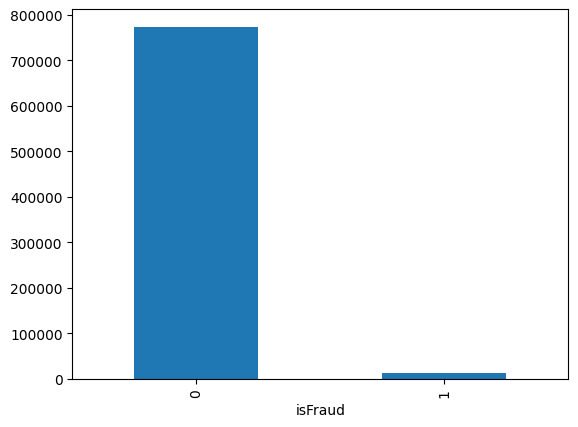

<Figure size 2500x1500 with 0 Axes>

In [ ]:
df['isFraud'].value_counts().plot(kind='bar')
plt.figure(figsize=(25,15))
plt.show()

In [ ]:
# Dataset is imbalanced after looking at the percentage of legit vs fraudulent transactions

In [ ]:
df.dtypes

accountNumber                       object
customerId                          object
creditLimit                        float64
availableMoney                     float64
transactionDateTime         datetime64[ns]
transactionAmount                  float64
merchantName                        object
acqCountry                          object
merchantCountryCode                 object
posEntryMode                        object
posConditionCode                    object
merchantCategoryCode                object
currentExpDate              datetime64[ns]
accountOpenDate             datetime64[ns]
dateOfLastAddressChange     datetime64[ns]
cardCVV                             object
enteredCVV                          object
cardLast4Digits                     object
transactionType                     object
echoBuffer                          object
currentBalance                     float64
merchantCity                        object
merchantState                       object
merchantZip

In [ ]:
# Converting categorical values -> One hot encoding

In [ ]:
df['transactionType'] = df['transactionType'].astype('category').cat.codes
df['merchantCity'] = df['merchantCity'].astype('category').cat.codes
df['merchantState'] = df['merchantState'].astype('category').cat.codes
df['merchantZip'] = df['merchantZip'].astype('category').cat.codes
df['merchantName'] = df['merchantName'].astype('category').cat.codes

In [ ]:
df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.00,2016-08-13 14:27:32,98.55,2086,US,US,02,...,,0.00,0,0,0,False,,,False,0
1,737265056,737265056,5000.0,5000.00,2016-10-11 05:05:54,74.51,27,US,US,09,...,,0.00,0,0,0,True,,,False,0
2,737265056,737265056,5000.0,5000.00,2016-11-08 09:18:39,7.47,1305,US,US,09,...,,0.00,0,0,0,False,,,False,0
3,737265056,737265056,5000.0,5000.00,2016-12-10 02:14:50,7.47,1305,US,US,09,...,,0.00,0,0,0,False,,,False,0
4,830329091,830329091,5000.0,5000.00,2016-03-24 21:04:46,71.18,2084,US,US,02,...,,0.00,0,0,0,True,,,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000.0,48904.96,2016-12-22 18:44:12,119.92,1061,US,US,90,...,,1095.04,0,0,0,False,,,False,0
786359,732852505,732852505,50000.0,48785.04,2016-12-25 16:20:34,18.89,2479,US,US,09,...,,1214.96,0,0,0,False,,,False,0
786360,732852505,732852505,50000.0,48766.15,2016-12-27 15:46:24,49.43,1061,US,US,02,...,,1233.85,0,0,0,False,,,False,0
786361,732852505,732852505,50000.0,48716.72,2016-12-29 00:30:55,49.89,2487,US,US,09,...,,1283.28,0,0,0,False,,,False,0


In [ ]:
# Selecting only relevant features
labels_to_drop = ['transactionDateTime', 'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
          'merchantCategoryCode', 'currentExpDate', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'transactionType', 'echoBuffer', 'merchantCity',
          'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises', 'recurringAuthInd', 'expirationDateKeyInMatch','accountOpenDate', 'dateOfLastAddressChange']

df = df.drop(labels=labels_to_drop, axis=1)

In [ ]:
df

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,currentBalance,isFraud
0,737265056,737265056,5000.0,5000.00,98.55,0.00,0
1,737265056,737265056,5000.0,5000.00,74.51,0.00,0
2,737265056,737265056,5000.0,5000.00,7.47,0.00,0
3,737265056,737265056,5000.0,5000.00,7.47,0.00,0
4,830329091,830329091,5000.0,5000.00,71.18,0.00,0
...,...,...,...,...,...,...,...
786358,732852505,732852505,50000.0,48904.96,119.92,1095.04,0
786359,732852505,732852505,50000.0,48785.04,18.89,1214.96,0
786360,732852505,732852505,50000.0,48766.15,49.43,1233.85,0
786361,732852505,732852505,50000.0,48716.72,49.89,1283.28,0


In [ ]:
# Splitting the data set into X(features) and Y(label)
X = df.drop(columns = 'isFraud', axis = 1)
Y = df['isFraud']

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

In [ ]:
# transform the dataset
oversample = BorderlineSMOTE(random_state=3)
X_smote, Y_smote = oversample.fit_resample(X, Y)

In [ ]:
print("Shape of X before oversampling", X.shape)
print("Shape of Y before oversampling", Y.shape)
print("Shape of X_smote before oversampling", X_smote.shape)
print("Shape of Y_smote before oversampling", Y_smote.shape)

Shape of X before oversampling (786363, 6)
Shape of Y before oversampling (786363,)
Shape of X_smote before oversampling (1547892, 6)
Shape of Y_smote before oversampling (1547892,)


In [ ]:
Y.value_counts()

isFraud
0    773946
1     12417
Name: count, dtype: int64

In [ ]:
Y_smote.value_counts()

isFraud
0    773946
1    773946
Name: count, dtype: int64

In [ ]:
# Splitting the dataset into X and Y
num_of_rows = X_smote.shape[0]
print(num_of_rows)

1547892


In [ ]:
import math
from sklearn.model_selection import train_test_split

In [ ]:
X_Train, X_Test, Y_Train_Label, Y_Test_Label = train_test_split(X_smote, Y_smote, test_size=0.2, random_state=42, stratify=Y_smote)

In [ ]:
# trainingSetSampleSize = math.floor(0.8*num_of_rows)
# print('No of Samples in Training Set:',trainingSetSampleSize)

In [ ]:
# X_Train = X_smote.iloc[:trainingSetSampleSize,:]
# Y_Train_Label = Y_smote.iloc[:trainingSetSampleSize]
print("The shape of the Training Fetaures dataset is :", X_Train.shape)
print("The shape of the Training Label dataset is :", Y_Train_Label.shape)

The shape of the Training Fetaures dataset is : (1238313, 6)
The shape of the Training Label dataset is : (1238313,)


In [ ]:
Y_Train_Label.value_counts()
# Y_Train_Label.value_counts().sum()

isFraud
1    619157
0    619156
Name: count, dtype: int64

In [ ]:
# X_Test = X_smote.iloc[trainingSetSampleSize:,:]
# Y_Test_Label = Y_smote.iloc[trainingSetSampleSize:]
print("The shape of the Test Fetaures dataset is :", X_Test.shape)
print("The shape of the Test Label dataset is :", Y_Test_Label.shape)

The shape of the Test Fetaures dataset is : (309579, 6)
The shape of the Test Label dataset is : (309579,)


In [ ]:
Y_Test_Label.value_counts()

isFraud
0    154790
1    154789
Name: count, dtype: int64

In [ ]:
model_Decision_Tree = DecisionTreeClassifier()
model_Decision_Tree = model_Decision_Tree.fit(X_Train, Y_Train_Label)

In [ ]:
model_Decision_Tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
train_predict = model_Decision_Tree.predict(X_Train)

In [ ]:
# Calculating accuracy of training set
training_accuracy = accuracy_score(Y_Train_Label,train_predict)
training_accuracy

0.9999967697989119

In [ ]:
prediction = model_Decision_Tree.predict(X_Test)

In [ ]:
prediction

array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
accuracy_score(Y_Test_Label, prediction)

0.9533980018024478

In [ ]:
confusion_matrix(Y_Test_Label,prediction, labels=[0,1])

array([[146520,   8270],
       [  6157, 148632]])

In [ ]:
precision_score(Y_Test_Label,prediction)

0.9472919401919669

In [ ]:
recall_score(Y_Test_Label,prediction)

0.9602232716795122

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_Test_Label, prediction))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95    154790
           1       0.95      0.96      0.95    154789

    accuracy                           0.95    309579
   macro avg       0.95      0.95      0.95    309579
weighted avg       0.95      0.95      0.95    309579



In [ ]:
# The model is clearly overfitting
# Next step would be to use Random Forrest and RandomisedSearchCV for hyperparameter tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model_RF = RandomForestClassifier()
model_RF = model_RF.fit(X_Train, Y_Train_Label)

In [ ]:
from scipy.stats import randint

In [ ]:
estimators = RandomForestClassifier(n_jobs = -1)
rf = {'max_depth':range(1, 100, 10),
      # 'n_estimators': [100, 200, 300],
      'max_features': ['auto', 'sqrt', 'log2'],
      # 'max_features': randint(1,3),
      'criterion': ['gini', 'entropy'],
      'bootstrap':[True,False],
      'min_samples_leaf': randint(1,4),
}



def hypertuning_rscv(estimators, param, no_of_iterations, X,Y):
    random_search = RandomizedSearchCV(estimators, param_distributions = param, n_iter = no_of_iterations,
                                       cv=4, scoring='roc_auc', n_jobs=-1, verbose = True)

    random_search.fit(X,Y)
    hyper_param = random_search.best_params_
    hyper_param_score = random_search.best_score_
    return hyper_param, hyper_param_score

rf_param, rf_ht_score = hypertuning_rscv(estimators,rf,10, X_smote, Y_smote)



Fitting 4 folds for each of 10 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [ ]:
Y_Train_Predict = model_RF.predict(X_Train)

In [ ]:
training_accuracy_rf = accuracy_score(Y_Train_Label,Y_Train_Predict)
print("The training accuracy is : ", training_accuracy_rf)

The training accuracy is :  0.9999725432907512


In [ ]:
Y_prediction = model_RF.predict(X_Test)

In [ ]:
test_accuracy_rf = accuracy_score(Y_Test_Label,Y_prediction)
print("The test accuracy is : ", test_accuracy_rf)

The test accuracy is :  0.9700884103895936


In [ ]:
from sklearn import metrics

In [ ]:
# cm = confusion_matrix(Y_Test_Label, Y_prediction)

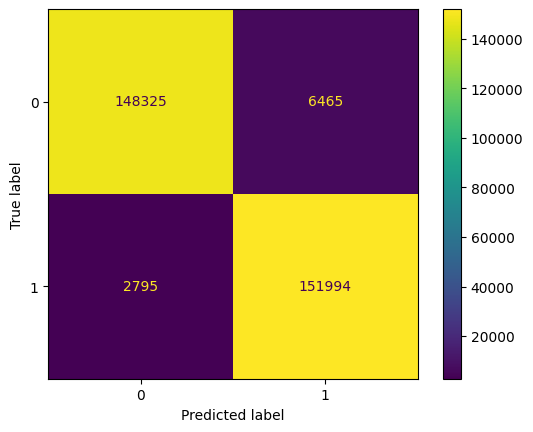

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(Y_Test_Label, Y_prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()


In [ ]:
confusion_matrix

array([[148325,   6465],
       [  2795, 151994]])

In [ ]:
TruePositive = confusion_matrix[0][0]
TrueNegative = confusion_matrix[1][1]
FalsePositive = confusion_matrix[0][1]
FalseNegative = confusion_matrix[1][0]
print("The True Positive Value is : ", TruePositive)
print("The True Negative Value is : ", TrueNegative)
print("The False Positive Value is : ", FalsePositive)
print("The False Negative Value is : ", FalseNegative)

The True Positive Value is :  148325
The True Negative Value is :  151994
The False Positive Value is :  6465
The False Negative Value is :  2795


In [170]:
pr = precision_score(Y_Test_Label,Y_prediction)
print("The precision value is : ", pr)

The precision value is :  0.9592008027313059


In [171]:
rs = recall_score(Y_Test_Label,Y_prediction)
print("The recall value is : ", rs)

The recall value is :  0.9819431613357539


In [172]:
f1_score = 2*(pr*rs)/(pr+rs)
print("The f1 score value is : ", f1_score)

The f1 score value is :  0.9704387577893554


The false positive rate is [0.         0.04176626 1.        ]
The true positive rate is [0.         0.98194316 1.        ]
The area under the ROC curve is 0.9700884486826066


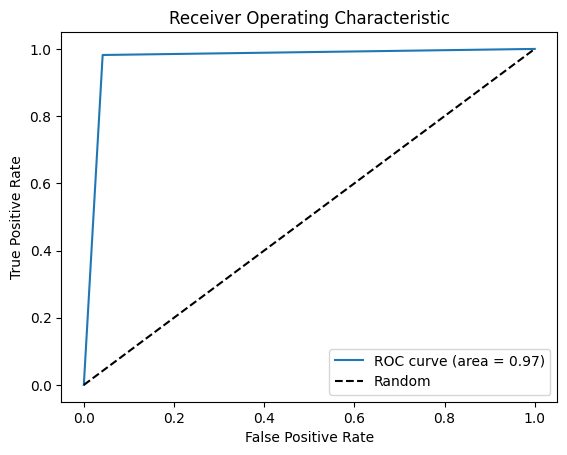

In [ ]:

from sklearn.metrics import roc_curve, auc
# Assuming you have y_test (true labels) and y_pred_proba (predicted probabilities)
fpr, tpr, thresholds = roc_curve(Y_Test_Label,Y_prediction)
roc_auc = auc(fpr, tpr)
print("The false positive rate is", fpr)
print("The true positive rate is", tpr)
print("The area under the ROC curve is", roc_auc)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()